In [52]:
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft
from IPython.display import Audio
import IPython
import librosa

In [53]:
Audio('audio.wav')

In [54]:
# zad 1.2
s, sf = sf.read('audio.wav', dtype='float32')

In [55]:
s.shape

(63800,)

In [56]:
sf

32000

In [57]:
sd.play(s, sf)

In [58]:
sd.stop()

In [59]:
duration_ms = len(s) / sf * 1000
duration_ms

1993.75

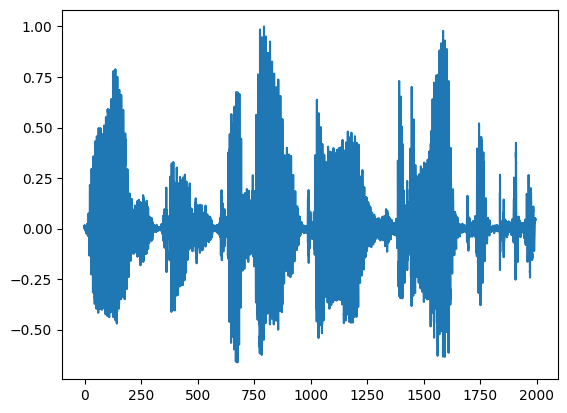

In [60]:
# zad 1.3
x = np.linspace(0, duration_ms, len(s))
plt.plot(x, s)
plt.show()

In [61]:
# zad 1.4
# dynamika jest odpowiednia i zakres amplitudy jest odpowiednio wykorzystywany, ponieważ 
# widzimy dużo skoków od niskich wartości do prawie maksymalnej amplitudy.
# przesterowanie nie występuje, ponieważ maksymalna wartość amplitudy to około 0.9, 
# a minimalna to około -0.6.
# szumu nie widać

In [62]:
# zad 2.1
def windowing(s, sf, window_size_ms):
    windows = []
    window_size = int(sf * window_size_ms / 1000)
    for i in range(len(s) // window_size):
        start_index = window_size * i
        end_index = window_size + start_index
        windows.append(s[start_index:end_index])
    return windows

def energy_zcr(s, sf, window_size_ms):
    windows = windowing(s, sf, window_size_ms)
    energies = []
    zcrs = []
    for window in windows:
        energies.append(np.sum([x ** 2 for x in window]))
        zcrs.append(np.sum(np.sign(window[:-1] * window[1:]) < 0).astype(int))
    energies = np.array(energies)
    zcrs = np.array(zcrs)
    energies = (energies - energies.min()) / (energies.max() - energies.min())
    zcrs = (zcrs - zcrs.min()) / (zcrs.max() - zcrs.min())
    return energies, zcrs

In [63]:
# zad 2.2
def plot_full(s, sf, duration_ms, energies, zcrs, window_size_ms):
    plt.figure(figsize=(12, 6))
    x = np.linspace(0, duration_ms, len(s))
    plt.plot(x, s, 'g', label='signal')
    window_size = int(sf * window_size_ms / 1000)
    x = np.linspace(0, duration_ms, len(s) // window_size)
    plt.plot(x, energies, 'r', label='energy (normalized)')
    plt.plot(x, zcrs, 'b', label='zero-crossing rate')
    plt.title(f"{window_size_ms} ms windows")
    plt.legend()
    plt.xlabel('time (ms)')
    plt.show()

In [64]:
# zad 2.3
# na podstawie poniższych wykresów, zauważyłem, że
# energia wskazuje na intensywność sygnału (podobnie jak amplituda), i ona jest większa w obszarach, 
# gdzię występują samogłoski, ale również dżwięczne samogłoski, np 'n' lub 'm'
# niską energię z kolei mają bezdżwięczne samogłoski, np. 't', 's', lub też cisza.
# wysoki ZCR wskazuje na intensywne zmiany znaku, co jest charakterystyczne dla spółgłosek bezdzwięcznych, 
# a niski ZCR - na odwrót.
# można rodzielic głoski na podstawie energii i ZCR: 
# samogłoski i spółgłoski dzwięczne - wysoka energia i niski ZCR, 
# spółgłoski bezdzięczne - niska energia i wysoki ZCR
# aczkolwiek w moim nagraniu też okazało się, że 'd' ma zarówno niską energię jak i niski ZCR, ale to raczej jest tylko przypadek

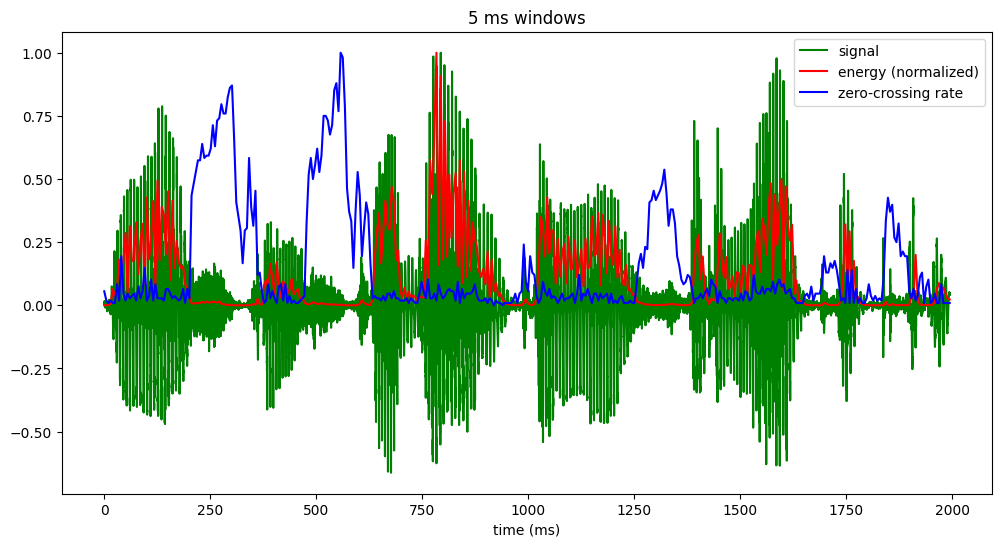

In [65]:
# zad 2.4
energies, zcrs = energy_zcr(s, sf, 5)
plot_full(s, sf, duration_ms, energies, zcrs, 5)

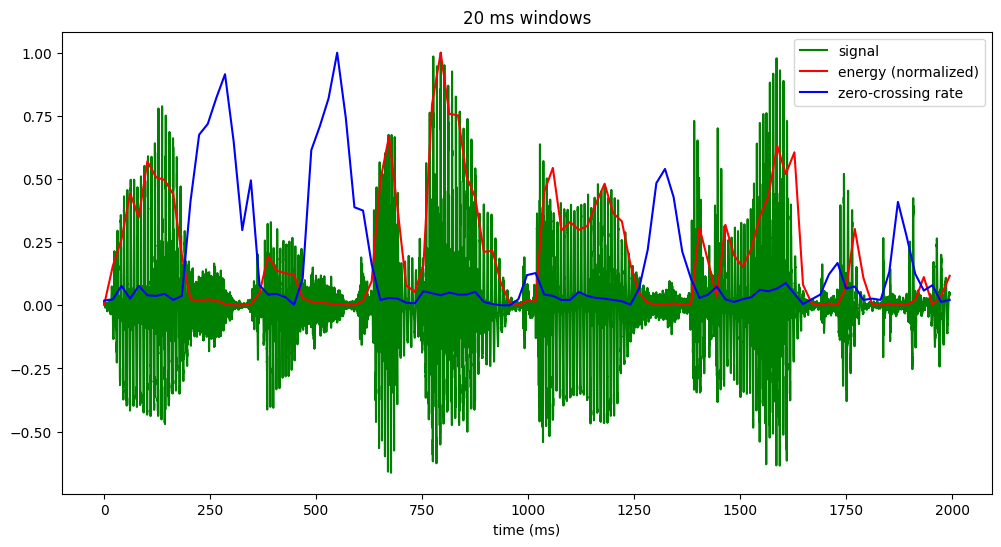

In [66]:
energies, zcrs = energy_zcr(s, sf, 20)
plot_full(s, sf, duration_ms, energies, zcrs, 20)

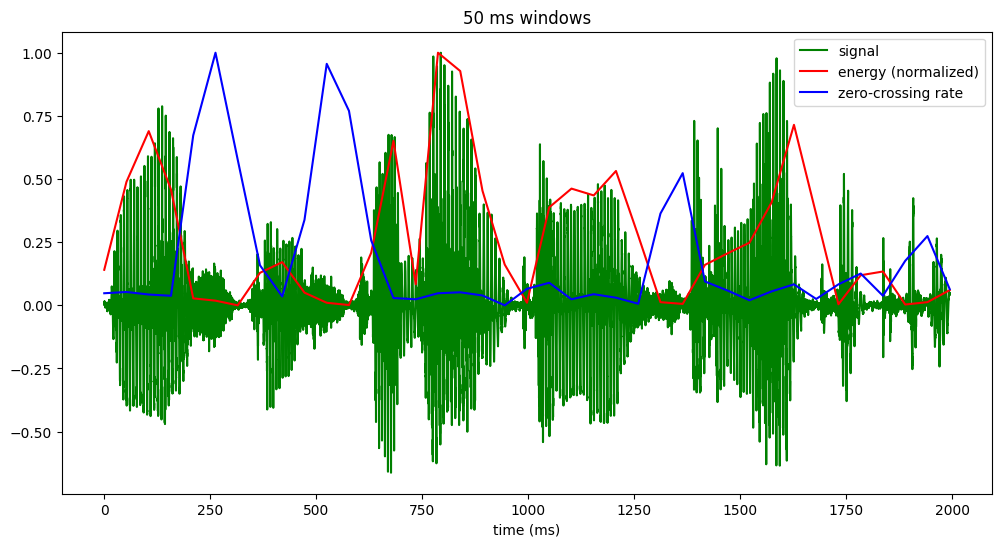

In [67]:
energies, zcrs = energy_zcr(s, sf, 50)
plot_full(s, sf, duration_ms, energies, zcrs, 50)

In [68]:
# zad 2.5
def windowing(s, sf, window_size_ms, overlap):
    windows = []
    window_size = int(sf * window_size_ms / 1000)
    step_size = int(window_size * (1 - overlap))
    for start_index in range(0, len(s) - window_size + 1, step_size):
        end_index = start_index + window_size
        windows.append(s[start_index:end_index])
    return windows
    
def energy_zcr(s, sf, window_size_ms, overlap):
    windows = windowing(s, sf, window_size_ms, overlap)
    energies = []
    zcrs = []
    for window in windows:
        energies.append(np.sum([x ** 2 for x in window]))
        zcrs.append(np.sum(np.sign(window[:-1] * window[1:]) < 0).astype(int))
    energies = np.array(energies)
    zcrs = np.array(zcrs)
    energies = (energies - energies.min()) / (energies.max() - energies.min())
    zcrs = (zcrs - zcrs.min()) / (zcrs.max() - zcrs.min())
    return energies, zcrs
    
def plot_full(s, sf, duration_ms, energies, zcrs, window_size_ms, overlap=0):
    x = np.linspace(0, duration_ms, len(s))
    plt.figure(figsize=(12, 6))
    plt.plot(x, s, 'g', label='signal')
    
    window_size = int(sf * window_size_ms / 1000)
    step_size = int(window_size * (1 - overlap))
    num_windows = (len(s) - window_size) // step_size + 1
    x = np.linspace(0, duration_ms, num_windows)
    plt.plot(x, energies, 'r', label='energy (normalized)')
    plt.plot(x, zcrs, 'b', label='zero-crossing rate')
    plt.title(f"{window_size_ms} ms windows with {overlap*100}% overlap")
    plt.xlabel('time (ms)')
    plt.legend()
    plt.show()

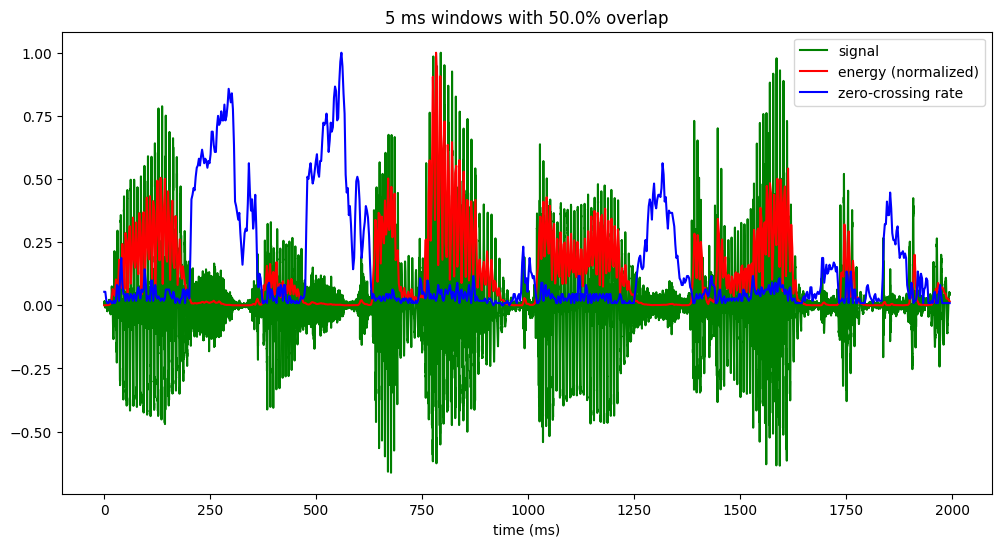

In [69]:
energies, zcrs = energy_zcr(s, sf, 5, 0.5)
plot_full(s, sf, duration_ms, energies, zcrs, 5, 0.5)
# nakładanie ramek pomaga zanalizować sygnał bardziej dokładnie bez zmniejszania czasu trwania ramek
# to zapewnia płynne przejścia i precyzyjną analizę

In [70]:
# zad 3.1
samogloska_e = s[26908:28956]
# samogloska_e = s[40000:44096]
sd.play(samogloska_e, sf)
samogloska_e.shape

(2048,)

In [71]:
# zad 3.1
samogloska_u = s[21080:23128]
sd.play(samogloska_u, sf)

In [72]:
# zad 3.1
samogloska_i = s[61752:63800]
sd.play(samogloska_i, sf)

In [73]:
# zad 3.1
samogloska_a = s[49104:51152]
sd.play(samogloska_a, sf)

In [74]:
# zad 3.1
samogloska_y = s[55818:57866]
sd.play(samogloska_y, sf)

In [75]:
# zad 3.1
samogloska_o = s[43200:45248]
sd.play(samogloska_o, sf)

In [76]:
samogloska = samogloska_a
def samogloska_analysis(s, sf=32000):
    duration_ms = len(s) / sf * 1000
    x = np.linspace(0, duration_ms, len(s))
    # zad 3.2
    hamming_window = np.hamming(len(s))
    masked = s * hamming_window
    # zad 3.3
    yf = np.log(np.abs(fft(masked)))
    xf = np.linspace(0, sf, len(yf))
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    axes[0, 0].plot(x, s)
    axes[0, 0].set_title('Signal')
    axes[0, 0].set_xlabel(f'time in ms ({len(s)} samples)')
    axes[0, 0].set_ylabel('Amplitude')

    axes[0, 1].plot(masked)
    axes[0, 1].set_title('Windowed Signal')
    axes[0, 1].set_xlabel(f'{len(s)} samples')
    axes[0, 1].set_ylabel('Amplitude')

    axes[1, 0].plot(xf, yf)
    axes[1, 0].set_title(f'Log-Amplitude Spectrum ({sf} Hz)')
    axes[1, 0].set_xlabel('Frequency')
    axes[1, 0].set_ylabel('Log-Amplitude')

    # zad 3.4
    x_len = int(len(yf) * 1000 / sf)
    xf_1000 = np.linspace(0, 1000, x_len)

    axes[1, 1].plot(xf_1000, yf[:x_len])
    axes[1, 1].set_title('Log-Amplitude Spectrum (1000 Hz)')
    axes[1, 1].set_xlabel('Frequency')
    axes[1, 1].set_ylabel('Log-Amplitude')
    tick_values = np.arange(0, 1000, 50)
    tick_labels = (tick_values).astype(str)
    axes[1, 1].set_xticks(tick_values)
    axes[1, 1].set_xticklabels(tick_labels)
    plt.show()

    return yf

a


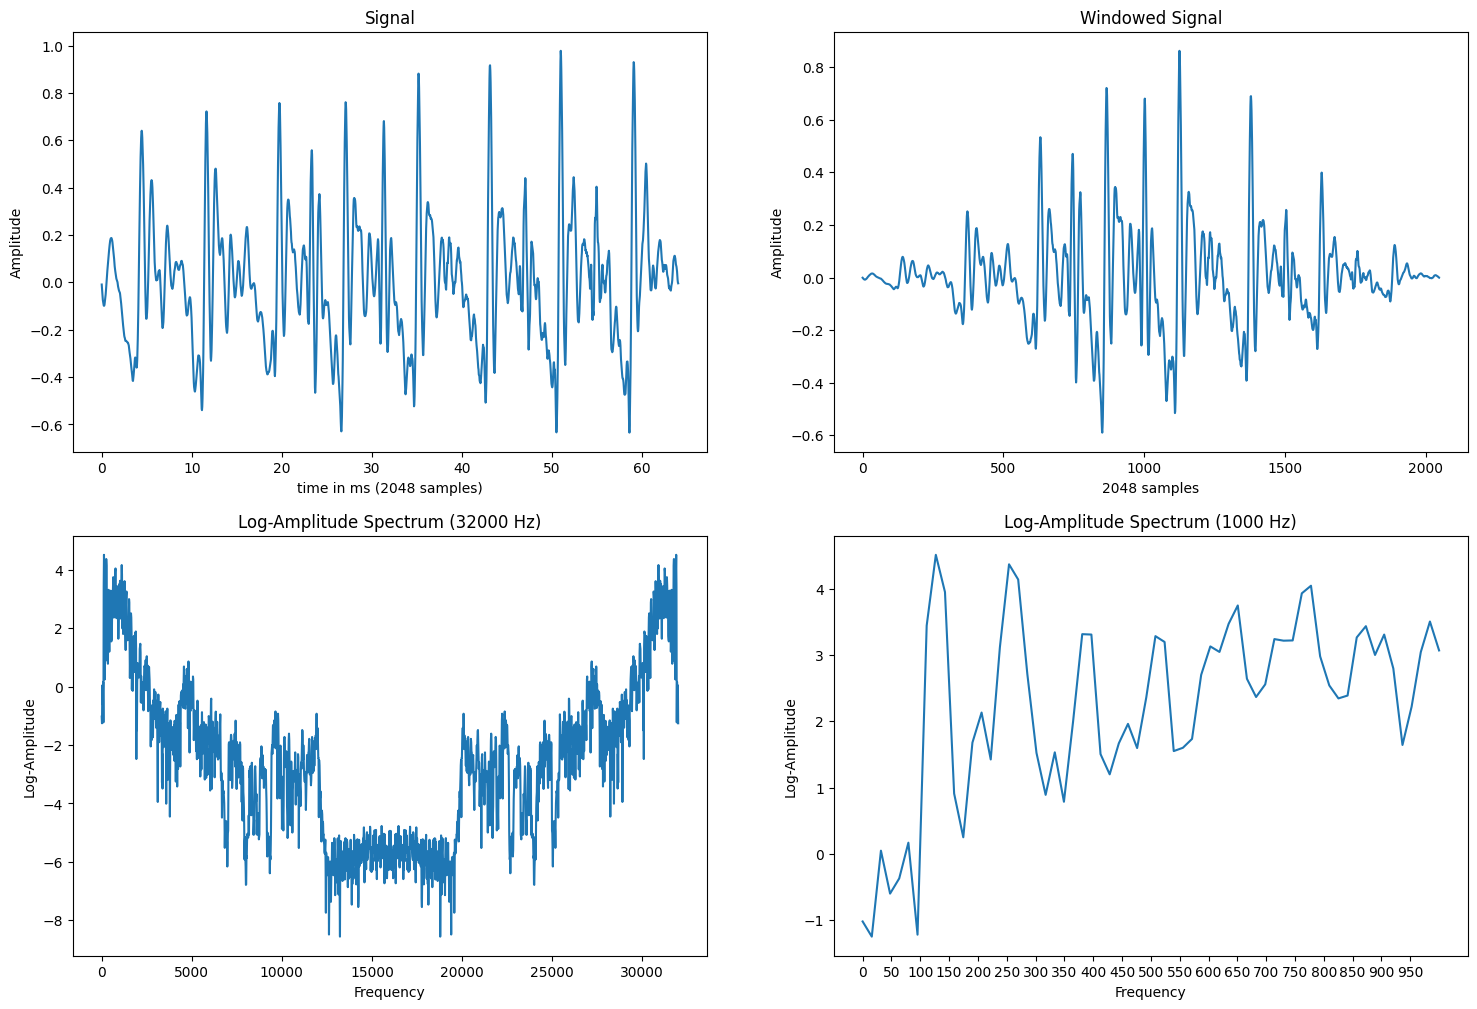

In [77]:
print('a')
yf_a = samogloska_analysis(samogloska_a, sf)
hamming_window = np.hamming(len(samogloska))
masked_samogloska = samogloska * hamming_window
# zad 3.5
# F0 = 130hz, F1 = 270 hz, F2 = 400 hz, F3 = 520 hz, jest dobrze

e


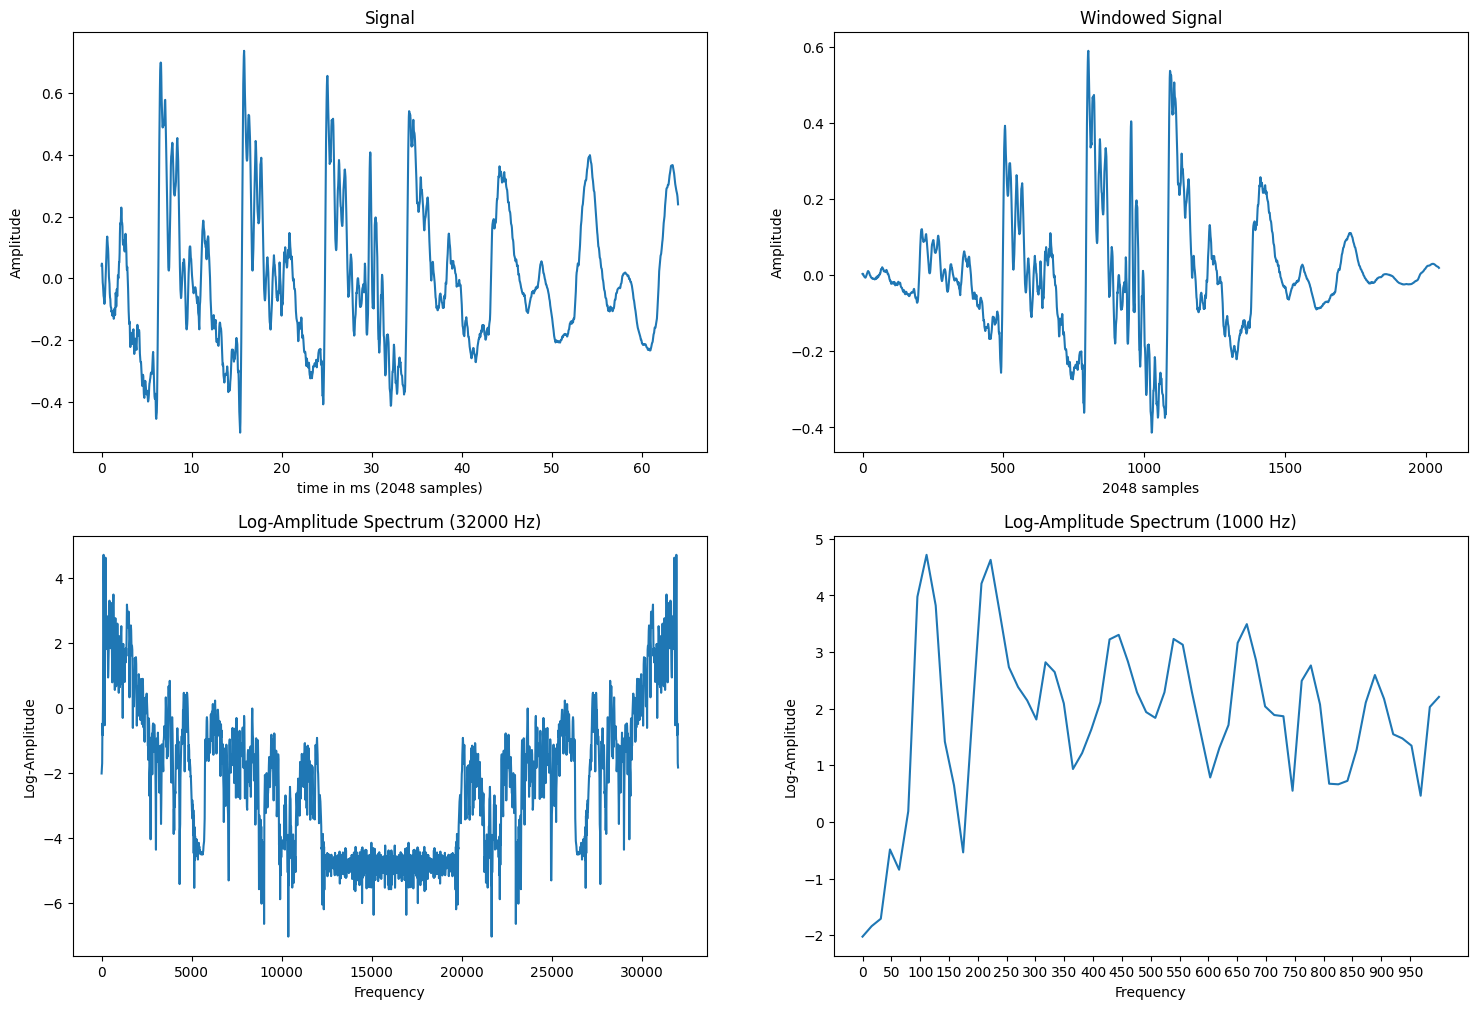

In [78]:
print('e')
yf_e = samogloska_analysis(samogloska_e, sf)
# zad 3.5
# F0 = 115 hz, F1 = 225 hz, F2 = 330 hz, F3 = 460 hz, jest dobrze

i


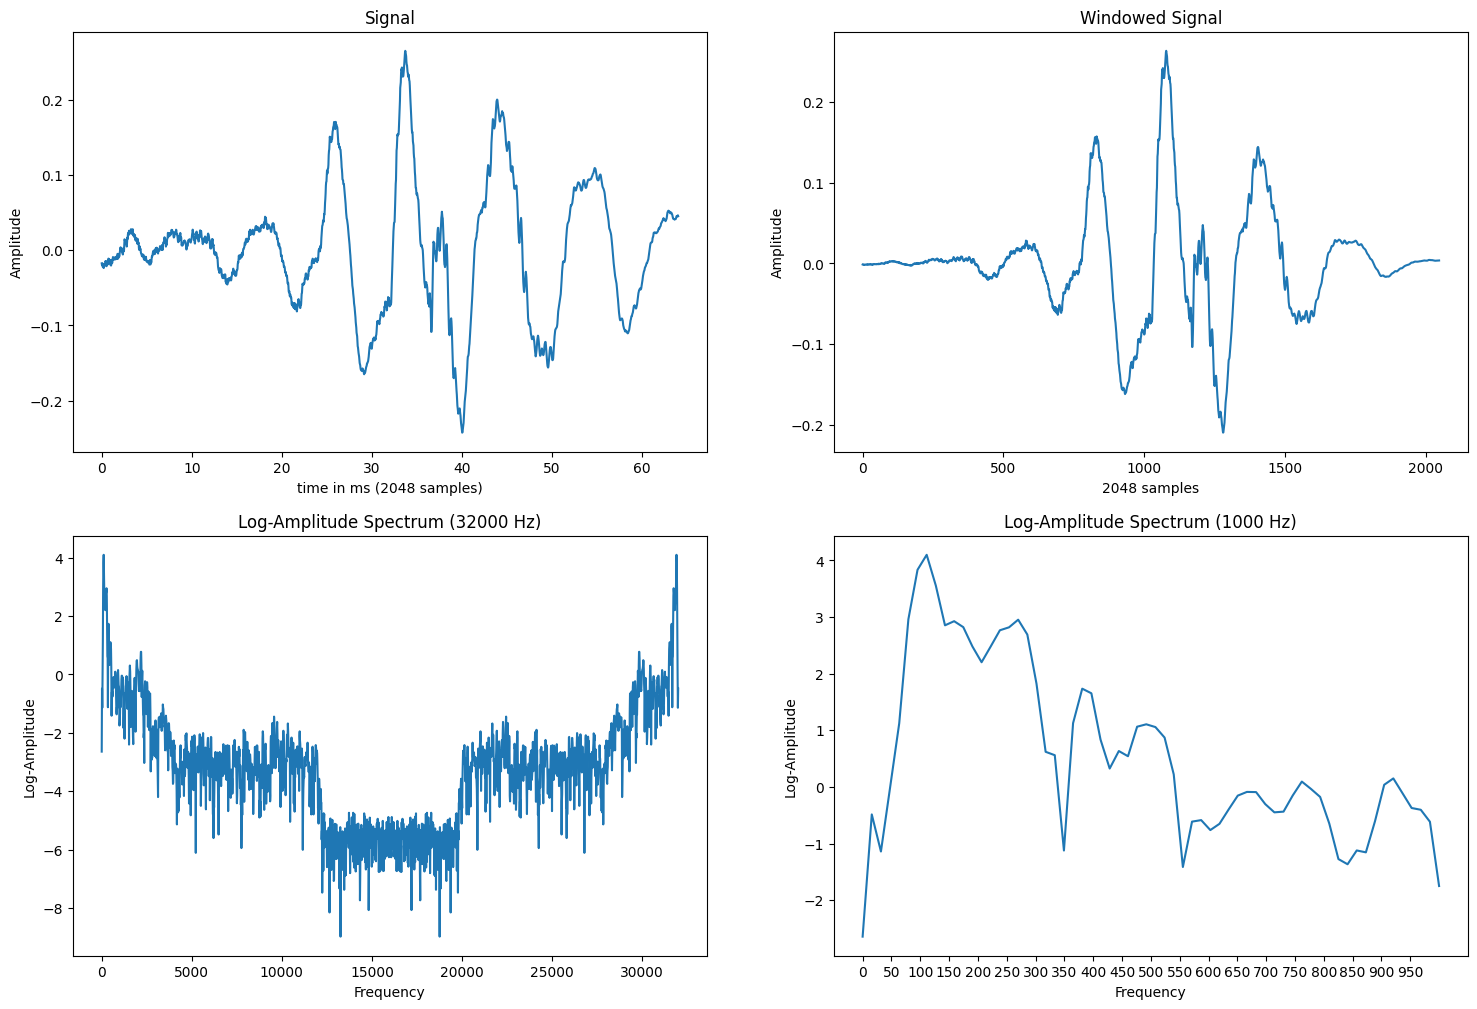

In [79]:
print('i')
yf_i = samogloska_analysis(samogloska_i, sf)
# zad 3.5
# F0 = 130 hz, F1 = 260 hz, F2 = 390 hz, F3 = 480 hz, jest dobrze

y


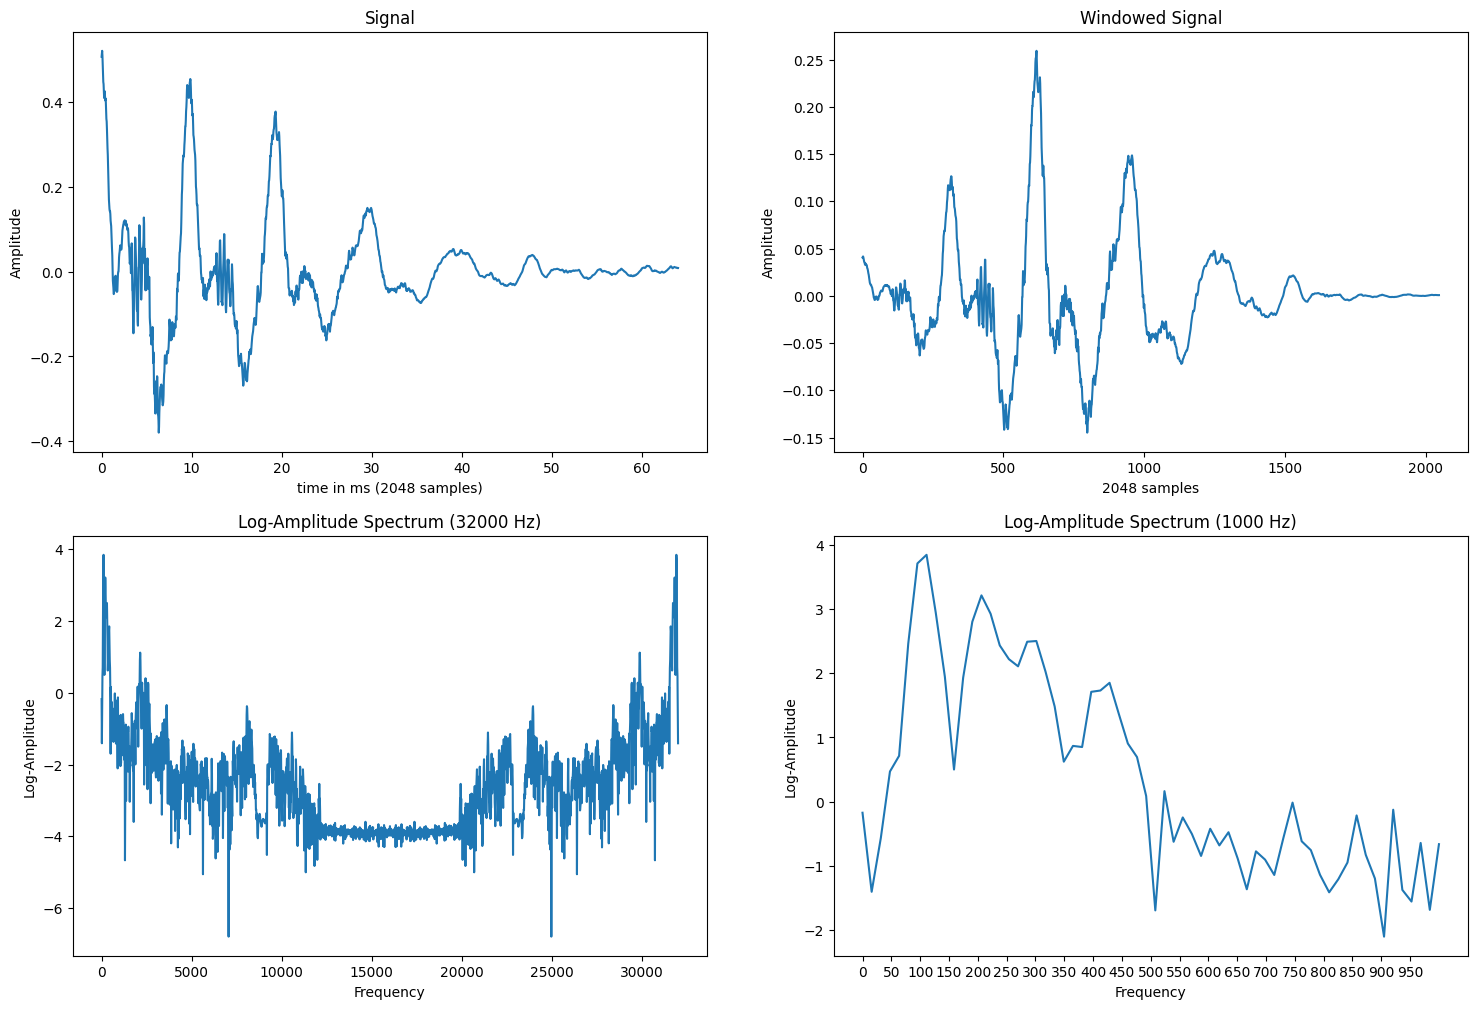

In [80]:
print('y')
yf_y = samogloska_analysis(samogloska_y, sf)
# zad 3.5
# F0 = 100 hz, F1 = 200 hz, F2 = 300 hz, F3 = 400 hz, jest dobrze

u


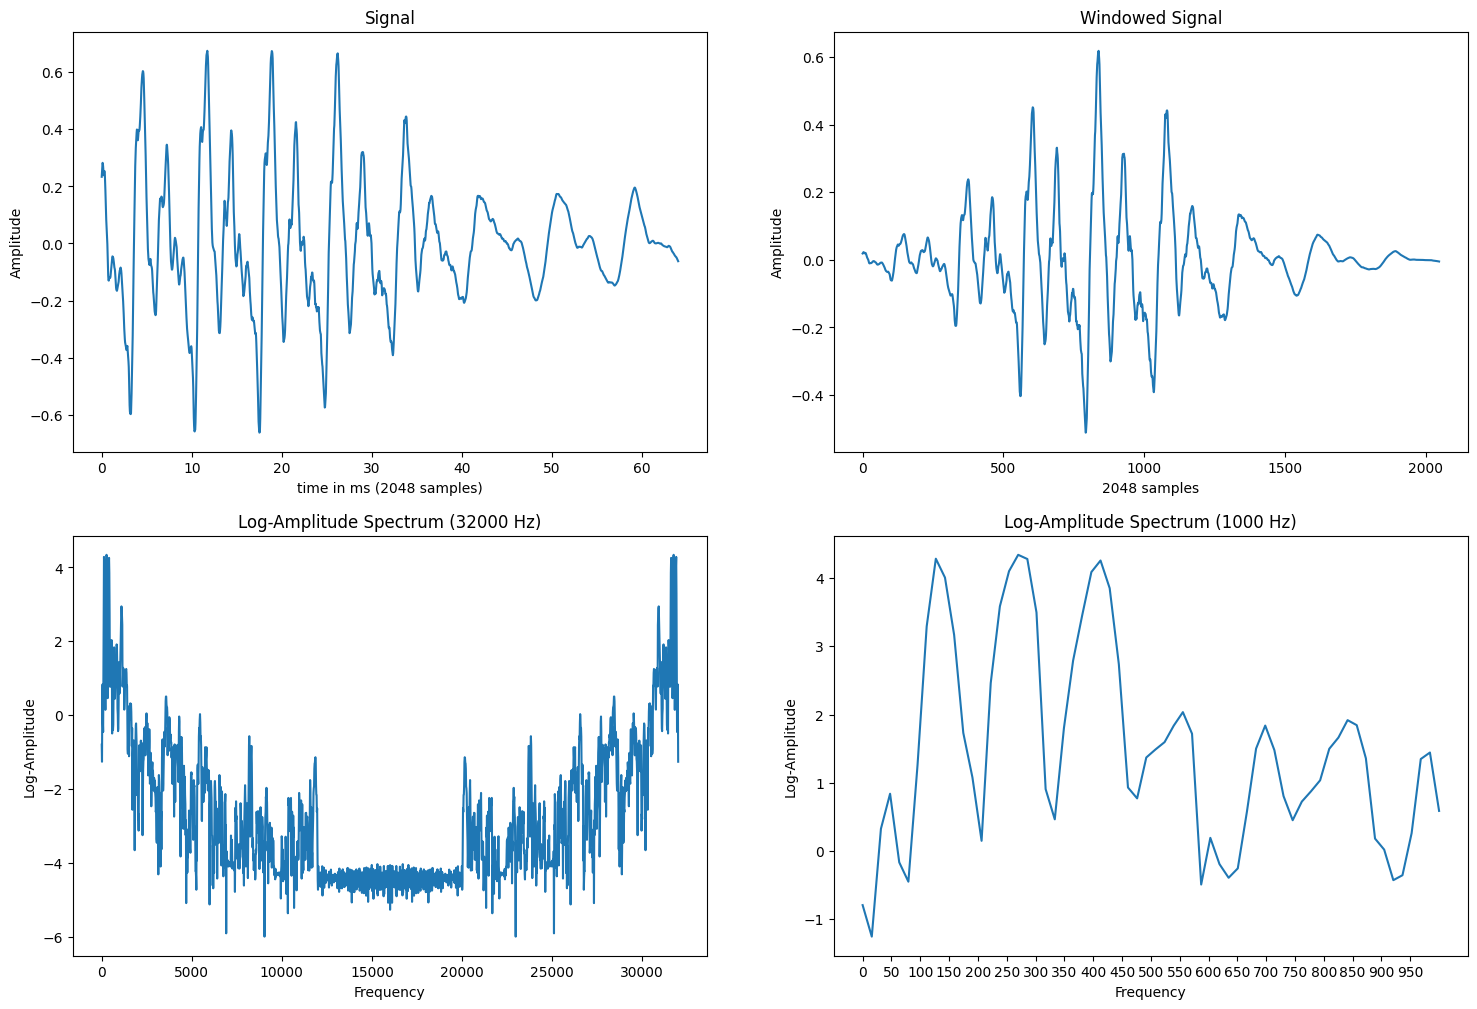

In [81]:
print('u')
yf_u = samogloska_analysis(samogloska_u, sf)
# zad 3.5
# F0 = 135 hz, F1 = 275 hz, F2 = 400 hz, F3 = 550 hz, jest dobrze

o


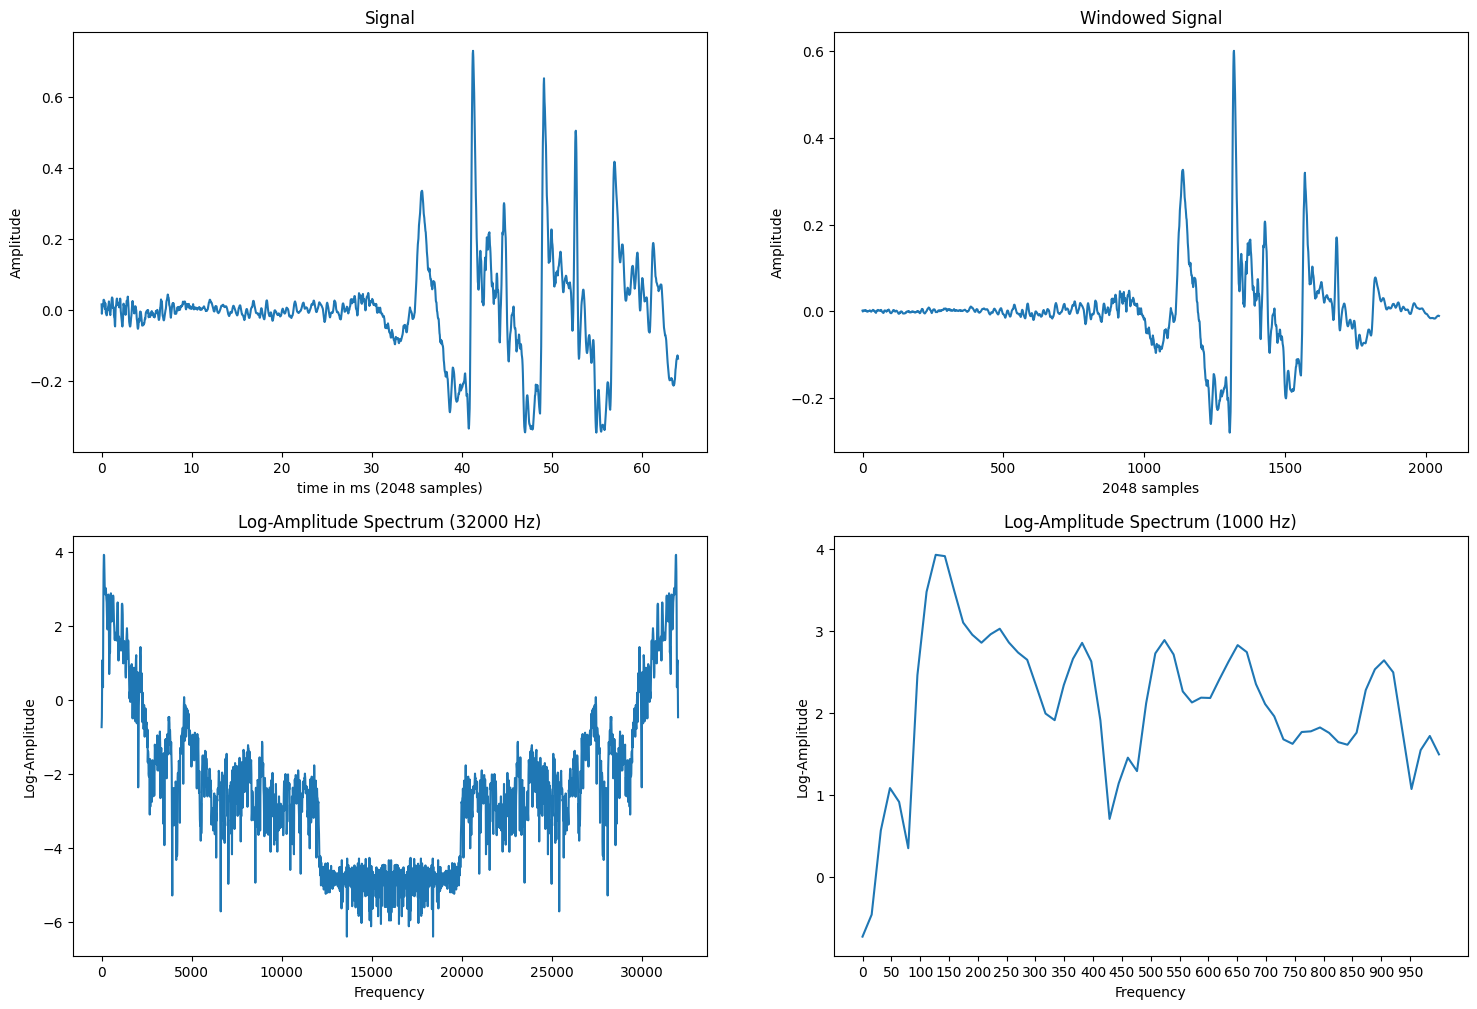

In [82]:
print('o')
yf_o = samogloska_analysis(samogloska_o, sf)
# zad 3.5
# F0 = 50 hz, F1 = 150 hz, F2 = 250 hz, F3 = 400 hz, jest źle

In [83]:
# zad 3.6
# Generalnie wszystkie badane głoski (samogłoski 'a', 'e', 'o', 'u', 'e', 'i', 'y') posiadają strukturę harmoniczną. 
# Widmo głosek dźwięcznych różni się od bezdźwięcznych tym, że bezdźwięczne nie mają częstotliwości harmonicznych na widmie
# Dla wszystkich (oprócz 'o') samogłosek harmoniczne są bardzo podobne, jak powinno być.
# W języku polskim nie ma bezdźwięcznych samogłosek ani też redukcji samogłosek, jak np. w języku angielskim, 
# a widma beżdzwięcznych spółgłosek nie sprawdzaliśmy
# ale w przypadku mojego nagrania można zauważyć, że 'o' jest bardzo krótka i zredukowana, dlatego jej 
# widmo wygląda najgorzej, ponieważ harmoniczne nie występują pomyślnie

In [84]:
# zad 4.1
okno = samogloska_e
# zad 4.2
p = 20
a = librosa.lpc(okno, order=p)

In [85]:
# zad 4.3
# Linear Predictive Coding (LPC) służy do przetwarzania sygnałów audio i mowy, a szczególnie do znajdowania tzw. formantów na widmie.
# Formanty to są harmoniczne o zwiększonej amplitudzie (w porównianiu do sąsiednich). Ponieważ różne samogłoski posiadają rożne formanty,
# można w ten sposób zidentyfikować samogłóskę

In [86]:
# zad 4.4
extended = np.zeros(len(okno))
extended[:21] = a

In [87]:
# zad 4.5
moLPC = np.log(np.abs(fft(extended)))
moLPC = moLPC * (-1)
moLPC = moLPC - 0.45

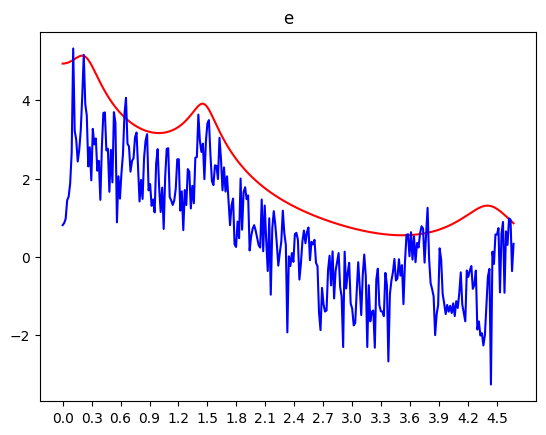

In [88]:
yf = np.log(np.abs(fft(samogloska_e)))
freq_axis = np.fft.fftfreq(len(okno), 1 / sf)
plt.plot(freq_axis[:300], moLPC[:300], c='r')
plt.plot(freq_axis[:300], yf[:300], c='b')
tick_values = np.arange(0, 4501, 300)
tick_labels = (tick_values / 1000).astype(str)  
plt.xticks(tick_values, tick_labels)
plt.title('e')
plt.show()
# nie udało się prawidłowo rozpoznać samogłoski 'e', F1 = 300 i F2 = 1400

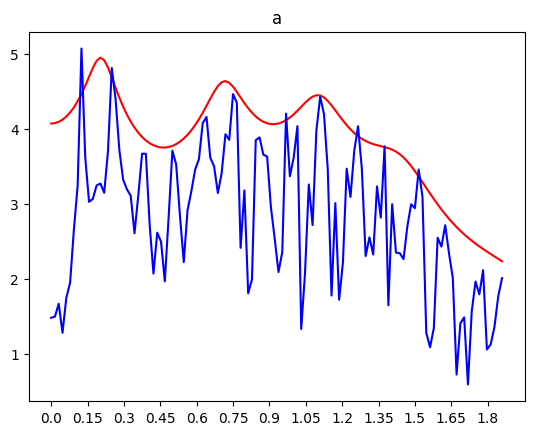

In [89]:
okno = samogloska_a
p = 60
a = librosa.lpc(okno, order=p)
extended = np.zeros(len(okno))
extended[:61] = a
moLPC = np.log(np.abs(fft(extended)))
moLPC = moLPC * (-1)
moLPC = moLPC - 1.05
yf = np.log(np.abs(fft(samogloska_a)))
freq_axis = np.fft.fftfreq(len(okno), 1 / sf)
plt.plot(freq_axis[:120], moLPC[:120], c='r')
plt.plot(freq_axis[:120], yf[:120], c='b')
tick_values = np.arange(0, 1801, 150)  # Original tick values
tick_labels = (tick_values / 1000).astype(str)  # Convert to labels in thousands

# Set custom ticks and labels
plt.xticks(tick_values, tick_labels)
plt.title('a')
plt.show()
# nie udało się rozpoznać samogłoskę 'a' w F1 = 200 hz i F2 = 700 hz

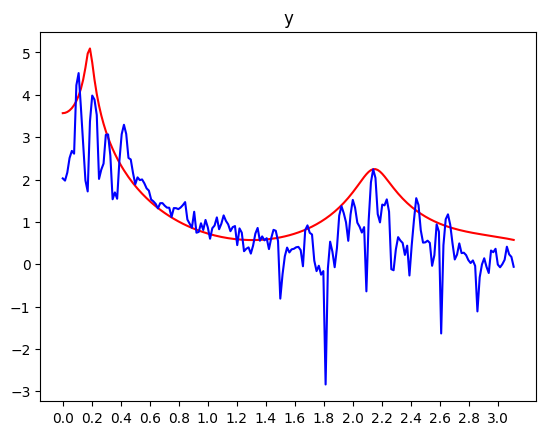

In [90]:
okno = samogloska_y
p = 20
a = librosa.lpc(okno, order=p)
extended = np.zeros(len(okno))
extended[:21] = a
moLPC = np.log(np.abs(fft(extended)))
moLPC = moLPC * (-1)
moLPC = moLPC - 1.1
yf = np.log(np.abs(fft(samogloska_y)))
freq_axis = np.fft.fftfreq(len(okno), 1 / sf)
plt.plot(freq_axis[:200], moLPC[:200], c='r')
plt.plot(freq_axis[:200], yf[:200], c='b')
plt.title('y')
tick_values = np.arange(0, 3001, 200)
tick_labels = (tick_values / 1000).astype(str) 
plt.xticks(tick_values, tick_labels)
plt.show()
# udało się rozpoznać samogłoskę 'y' w F1 = 250 Hz i F2 = 2100 Hz

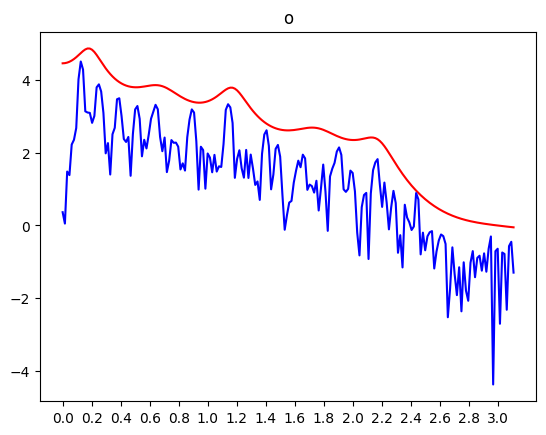

In [91]:
okno = samogloska_o
p = 50
a = librosa.lpc(okno, order=p)
extended = np.zeros(len(okno))
extended[:51] = a
moLPC = np.log(np.abs(fft(extended)))
moLPC = moLPC * (-1)
moLPC = moLPC - 0.8
yf = np.log(np.abs(fft(samogloska_o)))
freq_axis = np.fft.fftfreq(len(okno), 1 / sf)
plt.plot(freq_axis[:200], moLPC[:200], c='r')
plt.plot(freq_axis[:200], yf[:200], c='b')
plt.title('o')
tick_values = np.arange(0, 3001, 200)
tick_labels = (tick_values / 1000).astype(str) 
plt.xticks(tick_values, tick_labels)
plt.show()
# nie udało się rozpoznać samogłoski 'o', F1 = 200, F2 = 600 hz), bo okazała się bardzo krótka/zredukowana

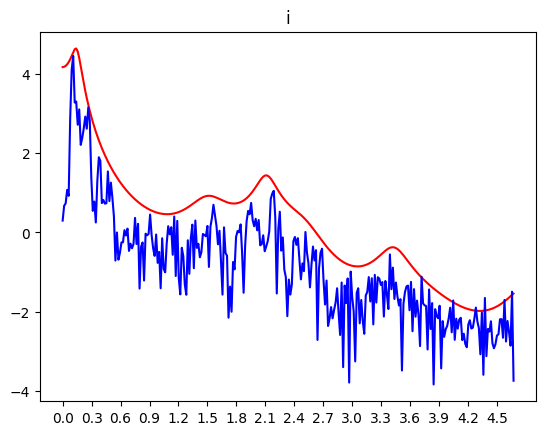

In [92]:
okno = samogloska_i
p = 50
a = librosa.lpc(okno, order=p)
extended = np.zeros(len(okno))
extended[:51] = a
moLPC = np.log(np.abs(fft(extended)))
moLPC = moLPC * (-1)
moLPC = moLPC - 1.7
yf = np.log(np.abs(fft(samogloska_i)))
freq_axis = np.fft.fftfreq(len(okno), 1 / sf)
plt.plot(freq_axis[:300], moLPC[:300], c='r')
plt.plot(freq_axis[:300], yf[:300], c='b')
tick_values = np.arange(0, 4600, 300)
tick_labels = (tick_values / 1000).astype(str) 
plt.xticks(tick_values, tick_labels)
plt.title('i')
plt.show()
# prawie udało się rozpoznać samogłoskę 'i' w F1 = 200 Hz i F2 = 1500 Hz

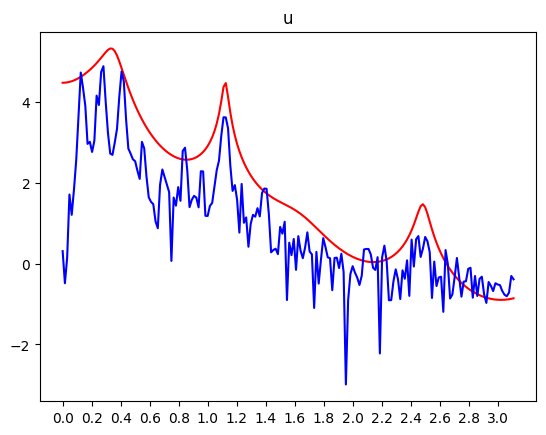

In [93]:
okno = samogloska_u
p = 50
a = librosa.lpc(okno, order=p)
extended = np.zeros(len(okno))
extended[:51] = a
moLPC = np.log(np.abs(fft(extended)))
moLPC = moLPC * (-1)
moLPC = moLPC - 1.5
yf = np.log(np.abs(fft(samogloska_u)))
freq_axis = np.fft.fftfreq(len(okno), 1 / sf)
plt.plot(freq_axis[:200], moLPC[:200], c='r')
plt.plot(freq_axis[:200], yf[:200], c='b')
plt.title('u')
tick_values = np.arange(0, 3001, 200)  # Original tick values
tick_labels = (tick_values / 1000).astype(str)  # Convert to labels in thousands
plt.xticks(tick_values, tick_labels)
plt.show()
# nie udało się rozpoznać samogłoskę 'u' w F1 = 200 Hz i F2 = 400 Hz 

In [94]:
# sprawdzenie z AI
import soundfile as sf

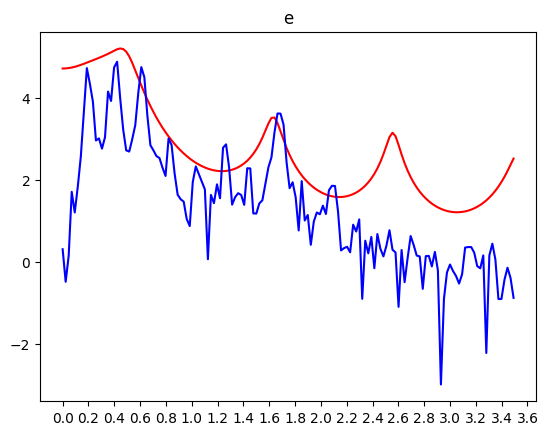

In [95]:
s, _ = sf.read('e.wav')
e = s[200:2248]
okno = e
p = 60
a = librosa.lpc(okno, order=p)
extended = np.zeros(len(okno))
extended[:61] = a
moLPC = np.log(np.abs(fft(extended)))
moLPC = moLPC * (-1)
moLPC = moLPC - 2.1
yf = np.log(np.abs(fft(samogloska_u)))
freq_axis = np.fft.fftfreq(len(okno), 1 / 48000)
plt.plot(freq_axis[:150], moLPC[:150], c='r')
plt.plot(freq_axis[:150], yf[:150], c='b')
plt.title('e')
tick_values = np.arange(0, 3601, 200)  # Original tick values
tick_labels = (tick_values / 1000).astype(str)  # Convert to labels in thousands
plt.xticks(tick_values, tick_labels)
plt.show()
# udało się rozpoznać samogłoskę 'e' w F1 = 500 i F2 = 1600 hz
Audio('e.wav')

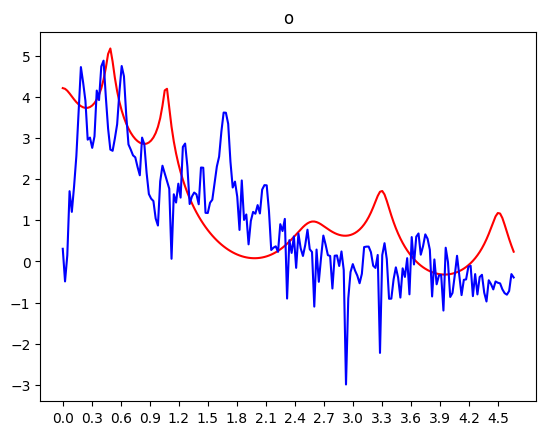

In [96]:
s, _ = sf.read('o.wav')
o = s[1000:3048]
okno = o
p = 50
a = librosa.lpc(okno, order=p)
extended = np.zeros(len(okno))
extended[:51] = a
moLPC = np.log(np.abs(fft(extended)))
moLPC = moLPC * (-1)
moLPC = moLPC - 3.0
yf = np.log(np.abs(fft(samogloska_u)))
freq_axis = np.fft.fftfreq(len(okno), 1 / 48000)
plt.plot(freq_axis[:200], moLPC[:200], c='r')
plt.plot(freq_axis[:200], yf[:200], c='b')
plt.title('o')
tick_values = np.arange(0, 4501, 300)  # Original tick values
tick_labels = (tick_values / 1000).astype(str)  # Convert to labels in thousands
plt.xticks(tick_values, tick_labels)
plt.show()
# prawie udało się rozpoznać samogłoskę 'o' w F1 = 500 i F2 = 1100 hz, ale PLC wygląda źle
Audio('o.wav')

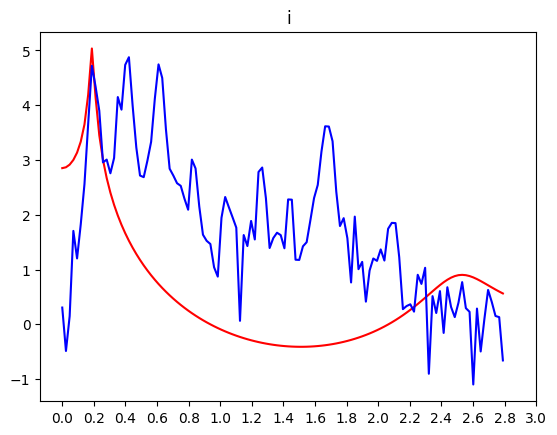

In [97]:
s, _ = sf.read('i.wav')
i = s[1000:3048]
okno = i
p = 30
a = librosa.lpc(okno, order=p)
extended = np.zeros(len(okno))
extended[:31] = a
moLPC = np.log(np.abs(fft(extended)))
moLPC = moLPC * (-1)
moLPC = moLPC - 2.9
yf = np.log(np.abs(fft(samogloska_u)))
freq_axis = np.fft.fftfreq(len(okno), 1 / 48000)
plt.plot(freq_axis[:120], moLPC[:120], c='r')
plt.plot(freq_axis[:120], yf[:120], c='b')
plt.title('i')
tick_values = np.arange(0, 3001, 200)  # Original tick values
tick_labels = (tick_values / 1000).astype(str)  # Convert to labels in thousands
plt.xticks(tick_values, tick_labels)
plt.show()
# "udało się" rozpoznać samogłoskę 'i' w F1 = 200 i F2 = 2500 hz, ale PLC jest źly
Audio('i.wav')

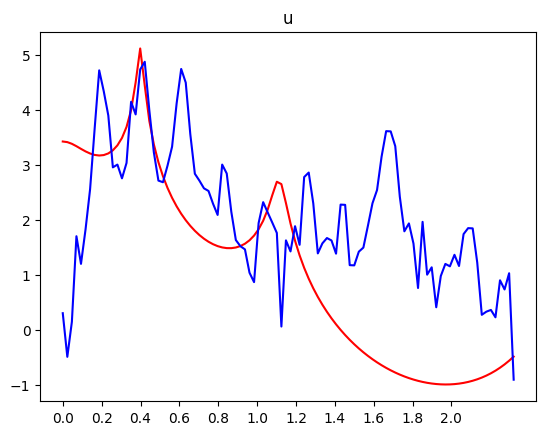

In [98]:
s, _ = sf.read('u.wav')
u = s[1000:3048]
okno = u
p = 50
a = librosa.lpc(okno, order=p)
extended = np.zeros(len(okno))
extended[:51] = a
moLPC = np.log(np.abs(fft(extended)))
moLPC = moLPC * (-1)
moLPC = moLPC - 3.9
yf = np.log(np.abs(fft(samogloska_u)))
freq_axis = np.fft.fftfreq(len(okno), 1 / 48000)
plt.plot(freq_axis[:100], moLPC[:100], c='r')
plt.plot(freq_axis[:100], yf[:100], c='b')
plt.title('u')
tick_values = np.arange(0, 2001, 200)
tick_labels = (tick_values / 1000).astype(str)
plt.xticks(tick_values, tick_labels)
plt.show()
# prawie udało się rozpoznać samogłoskę 'u' w F1 = 400 i F2 = 1100 hz
Audio('u.wav')

In [51]:
# zauważyłem, że parameter 'order' w funkcji lpc z librosa wpływa na wykrywanie formant. zbyt niska wartość może 
# skutkować utratą formant. wysoka wartość może skutkować fałszywymi formantami, np. szumem przypadkowymi wibracjami.